# Behavioral Cloning


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import cv2

import ntpath
import random

from imgaug import augmenters as ima

In [2]:
%load_ext autoreload
%autoreload 2

I created the `vehicle_control` module for this project.

In [3]:
from vehicle_control.model.data_manager import DataManager
from vehicle_control.model.model_builder import VehicleControlModelBuilder
from vehicle_control.model.model_trainer import ModelTrainer
from vehicle_control.model.image_augmentor import ImageAugmentor
from vehicle_control.model.batch_image_generator import BatchImageGenerator

## Explore the Test Data from the Self-driving Car Simulator

This shows the directory structure and contents for this project.

In [4]:
!ls

CarND.yml       README.md       drive_sdcar.py  output_images
Models          Simulator       images          vehicle_control
README copy.md  data            model.ipynb     video.py


The `Data` directory contains the data generated by the simulator during training. I trained it in multiple runs. E.g., the data from one run is stored in `Driving Dataset 01`, while the data from a second run is stored in `Driving Dataset 02`. This notebook uses the second set of data I captured.

In [5]:
!ls "data/"

bridge_dataset    driving_dataset_X recovery_dataset
combined          new


It captures images as `JPG` files from each of the three cameras, and stores them in the `Data/IMG` directory. The file `driving_log.csv` contains a summary of the data. We will explore its contents a little further down. 

In [6]:
!ls "data/new/IMG" | wc -l

   57435


There are over 40,000 images in the test data set. These were genereated from performing 4 laps of the driving circuit, in each direction for a total of 8 laps. The reason I drove the car in both directions is to get a better dataset. Driving in one direction would result in most of the turns being left turns or right turns, depending on the direction of driving. Driving the same number of times around the track in both directions gives a more even distribution of data, which I verify below.

Let's look at the first few images from the left camera, the center camera, and the right camera.

In [7]:
!ls "data/new/IMG/" | grep 'left*' | head -3
!ls "data/new/IMG/" | grep 'center*' | head -3
!ls "data/new/IMG/" | grep 'right*' | head -3

left_2021_07_02_16_12_36_240.jpg
left_2021_07_02_16_12_36_308.jpg
left_2021_07_02_16_12_36_376.jpg
center_2021_07_02_16_12_36_240.jpg
center_2021_07_02_16_12_36_308.jpg
center_2021_07_02_16_12_36_376.jpg
right_2021_07_02_16_12_36_240.jpg
right_2021_07_02_16_12_36_308.jpg
right_2021_07_02_16_12_36_376.jpg


In [8]:
datadir = 'data/new'
datafile = 'driving_log.csv'

data_manager = DataManager(datadir, datafile)

In [9]:
data_manager.get_data().head()

center                              left  \
0  center_2021_07_02_16_12_36_240.jpg  left_2021_07_02_16_12_36_240.jpg   
1  center_2021_07_02_16_12_36_308.jpg  left_2021_07_02_16_12_36_308.jpg   
2  center_2021_07_02_16_12_36_376.jpg  left_2021_07_02_16_12_36_376.jpg   
3  center_2021_07_02_16_12_36_444.jpg  left_2021_07_02_16_12_36_444.jpg   
4  center_2021_07_02_16_12_36_512.jpg  left_2021_07_02_16_12_36_512.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2021_07_02_16_12_36_240.jpg       0.0       0.0      0.0  0.000003  
1  right_2021_07_02_16_12_36_308.jpg       0.0       0.0      0.0  0.000012  
2  right_2021_07_02_16_12_36_376.jpg       0.0       0.0      0.0  0.000017  
3  right_2021_07_02_16_12_36_444.jpg       0.0       0.0      0.0  0.000003  
4  right_2021_07_02_16_12_36_512.jpg       0.0       0.0      0.0  0.000017

In [10]:
data_manager.get_data().tail()

center                              left  \
19140  center_2021_07_02_16_44_54_180.jpg  left_2021_07_02_16_44_54_180.jpg   
19141  center_2021_07_02_16_44_54_251.jpg  left_2021_07_02_16_44_54_251.jpg   
19142  center_2021_07_02_16_44_54_318.jpg  left_2021_07_02_16_44_54_318.jpg   
19143  center_2021_07_02_16_44_54_389.jpg  left_2021_07_02_16_44_54_389.jpg   
19144  center_2021_07_02_16_44_54_473.jpg  left_2021_07_02_16_44_54_473.jpg   

                                   right  steering  throttle  reverse  \
19140  right_2021_07_02_16_44_54_180.jpg       0.0       0.0      0.0   
19141  right_2021_07_02_16_44_54_251.jpg       0.0       0.0      0.0   
19142  right_2021_07_02_16_44_54_318.jpg       0.0       0.0      0.0   
19143  right_2021_07_02_16_44_54_389.jpg       0.0       0.0      0.0   
19144  right_2021_07_02_16_44_54_473.jpg       0.0       0.0      0.0   

          speed  
19140  4.977977  
19141  4.937973  
19142  4.908181  
19143  4.868737  
19144  4.839233

Merge the data from all the datasets into a single dataframe:

### Steering angle data
We will be using the steering angle data to train the network to steer the car. 

Plot the steering angles on a distribution, to see which angles are most frequent.

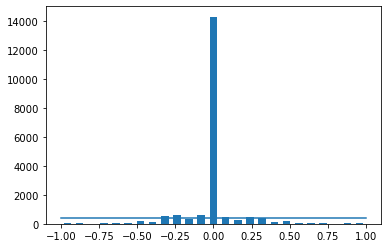

In [11]:
num_bins = 25
max_samples_per_bin = 400

hist, bins = np.histogram(data_manager.steering_data(), num_bins)

center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data_manager.steering_data()), 
          np.max(data_manager.steering_data())), 
         (max_samples_per_bin, max_samples_per_bin))

As might be expected, this shows that the angle of `0.0`, representing straight ahead, is the most common steering angle. However, for the purposes of training our neural network, this presents a problem because the center value dominate all other values, which would introduce bias in training our network.

The solution is to remove a set of the data from the center of the dataset, which results in a more normalized distribution of the data.

In [12]:
data_manager.normalize_steering_data()

total data 19145
removed: 14554
remaining: 4591


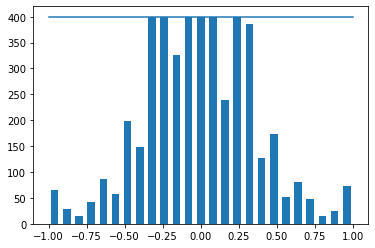

In [13]:
hist, _ = np.histogram(data_manager.steering_data(), (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data_manager.steering_data()), 
          np.max(data_manager.steering_data())), 
         (max_samples_per_bin, max_samples_per_bin))             

## Training and Validation Split

In [14]:
print(data_manager.get_data().iloc[1])

center      center_2021_07_02_16_12_37_822.jpg
left          left_2021_07_02_16_12_37_822.jpg
right        right_2021_07_02_16_12_37_822.jpg
steering                                 -0.35
throttle                                   0.0
reverse                                    0.0
speed                                 0.397026
Name: 23, dtype: object


In [15]:
X_train, X_valid, y_train, y_valid = data_manager.training_and_test_data()

print('Training samples: {}'.format(len(X_train)))
print('Validation samples: {}'.format(len(X_valid)))

Training samples: 3672
Validation samples: 919


Text(0.5, 1.0, 'Validation set')

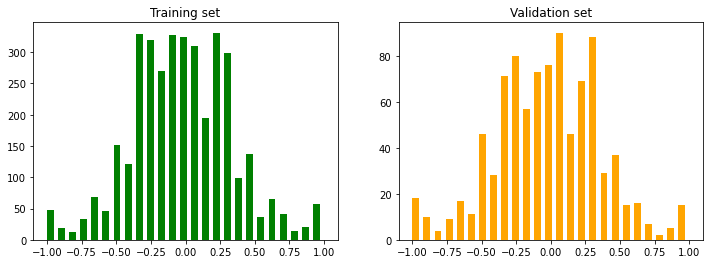

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='green')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='orange')
axes[1].set_title('Validation set')

## Generate additional data using augmentation techniques

As discussed in chapter 2 of the Dissertation document, applying augmentation techniques is a useful way to create more data from our existing data. This section of the notebook shows how I use zooming, panning, brightness, and flipping to create additional data for training the network. I then randomly apply multiple augmentations to the orginal data, so that, for example, one input image could result in an output image that is a variation that is flipped, rotated, and made brighter.

In [48]:
image_paths, steering_data = data_manager.image_and_steering_data()

Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path


Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path


Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path


Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path


Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path


Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path
Adding left and right camera images to image_path


### Utility Functions

In [49]:
def plot_two_images(image1, image2, title1="Image 1", title2="Image 2"):
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    fig.tight_layout()

    axes[0].imshow(image1)
    axes[0].set_title(title1)

    axes[1].imshow(image2)
    axes[1].set_title(title2)

### Zooming

In [50]:
image_augmentor = ImageAugmentor()

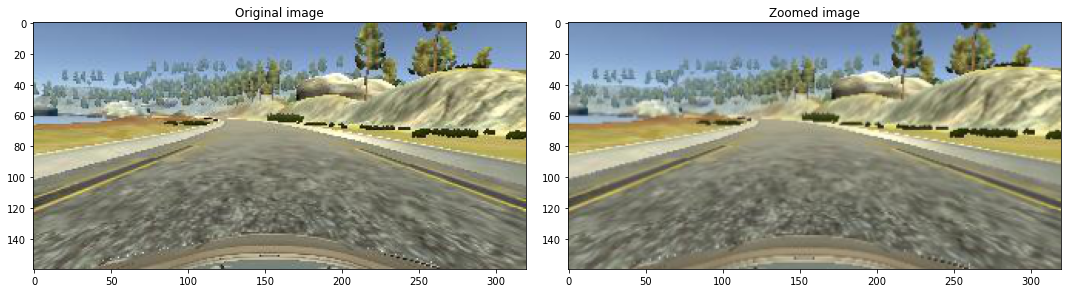

In [51]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)

zoomed_image = image_augmentor.zoom(original_image)

plot_two_images(original_image, zoomed_image, "Original image", "Zoomed image")

### Image panning

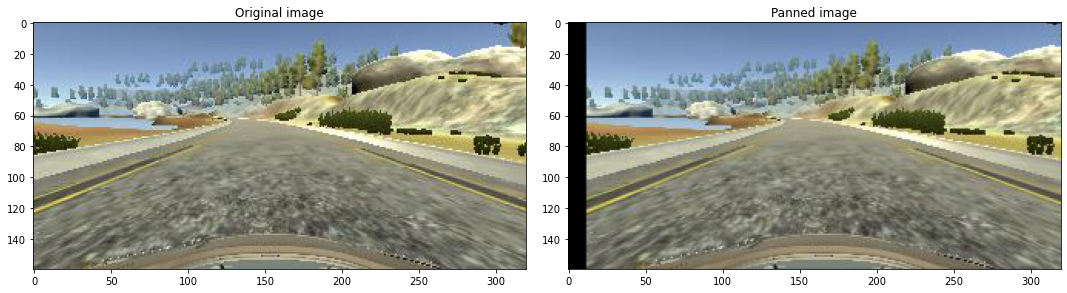

In [52]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)

panned_image = image_augmentor.pan(original_image)

plot_two_images(original_image, panned_image, "Original image", "Panned image")

### Image brightness

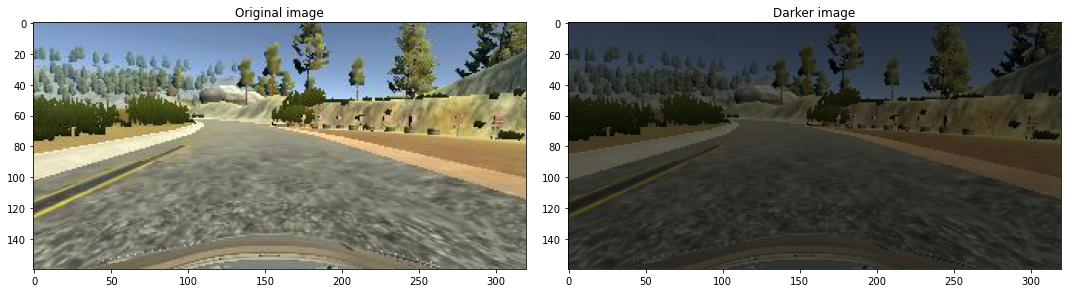

In [53]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)

darker_image = image_augmentor.randomly_alter_brightness(original_image)

plot_two_images(original_image, darker_image, "Original image", "Darker image")

### Flipping

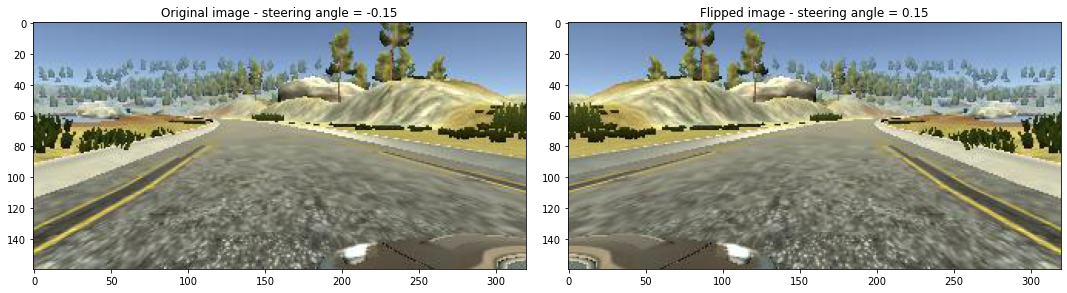

In [54]:
random_index = random.randint(0,1000)
image = image_paths[random_index]
steering_angle = steering_data[random_index]


original_image = mpimg.imread(image)

flipped_image, flipped_steering_angle = image_augmentor.flip(original_image, steering_angle)

plot_two_images(
    original_image, 
    flipped_image, 
    "Original image - steering angle = {}".format(steering_angle), 
    "Flipped image - steering angle = {}".format(flipped_steering_angle)
)

### Randomly apply the augmentations
Note it may look like more than one transformation is being applied to a given original image, e.g., the augmented image may be flipped and darkened.

In [68]:
def plot_ten_random_augmented_images():
    columns = 2
    rows = 10

    fig, axs = plt.subplots(rows, columns, figsize=(15, 50))
    fig.tight_layout()

    for i in range(10):
        random_index = random.randint(0, len(data_manager.steering_data()) - 1)
        random_image = image_paths[random_index]
        random_steering_angle = steering_data[random_index]

        original_image = mpimg.imread(random_image)
        augmented_image, augmented_steering_angle, augmentation_type = \
            image_augmentor.random_augment(random_image, random_steering_angle)

        axs[i][0].imshow(original_image)
        axs[i][0].set_title("Original image - steering angle = {}"\
                            .format(random_steering_angle))
        axs[i][1].imshow(augmented_image)
        axs[i][1].set_title("Augmented image ({}) - steering angle = {}"\
                            .format(augmentation_type ,augmented_steering_angle))

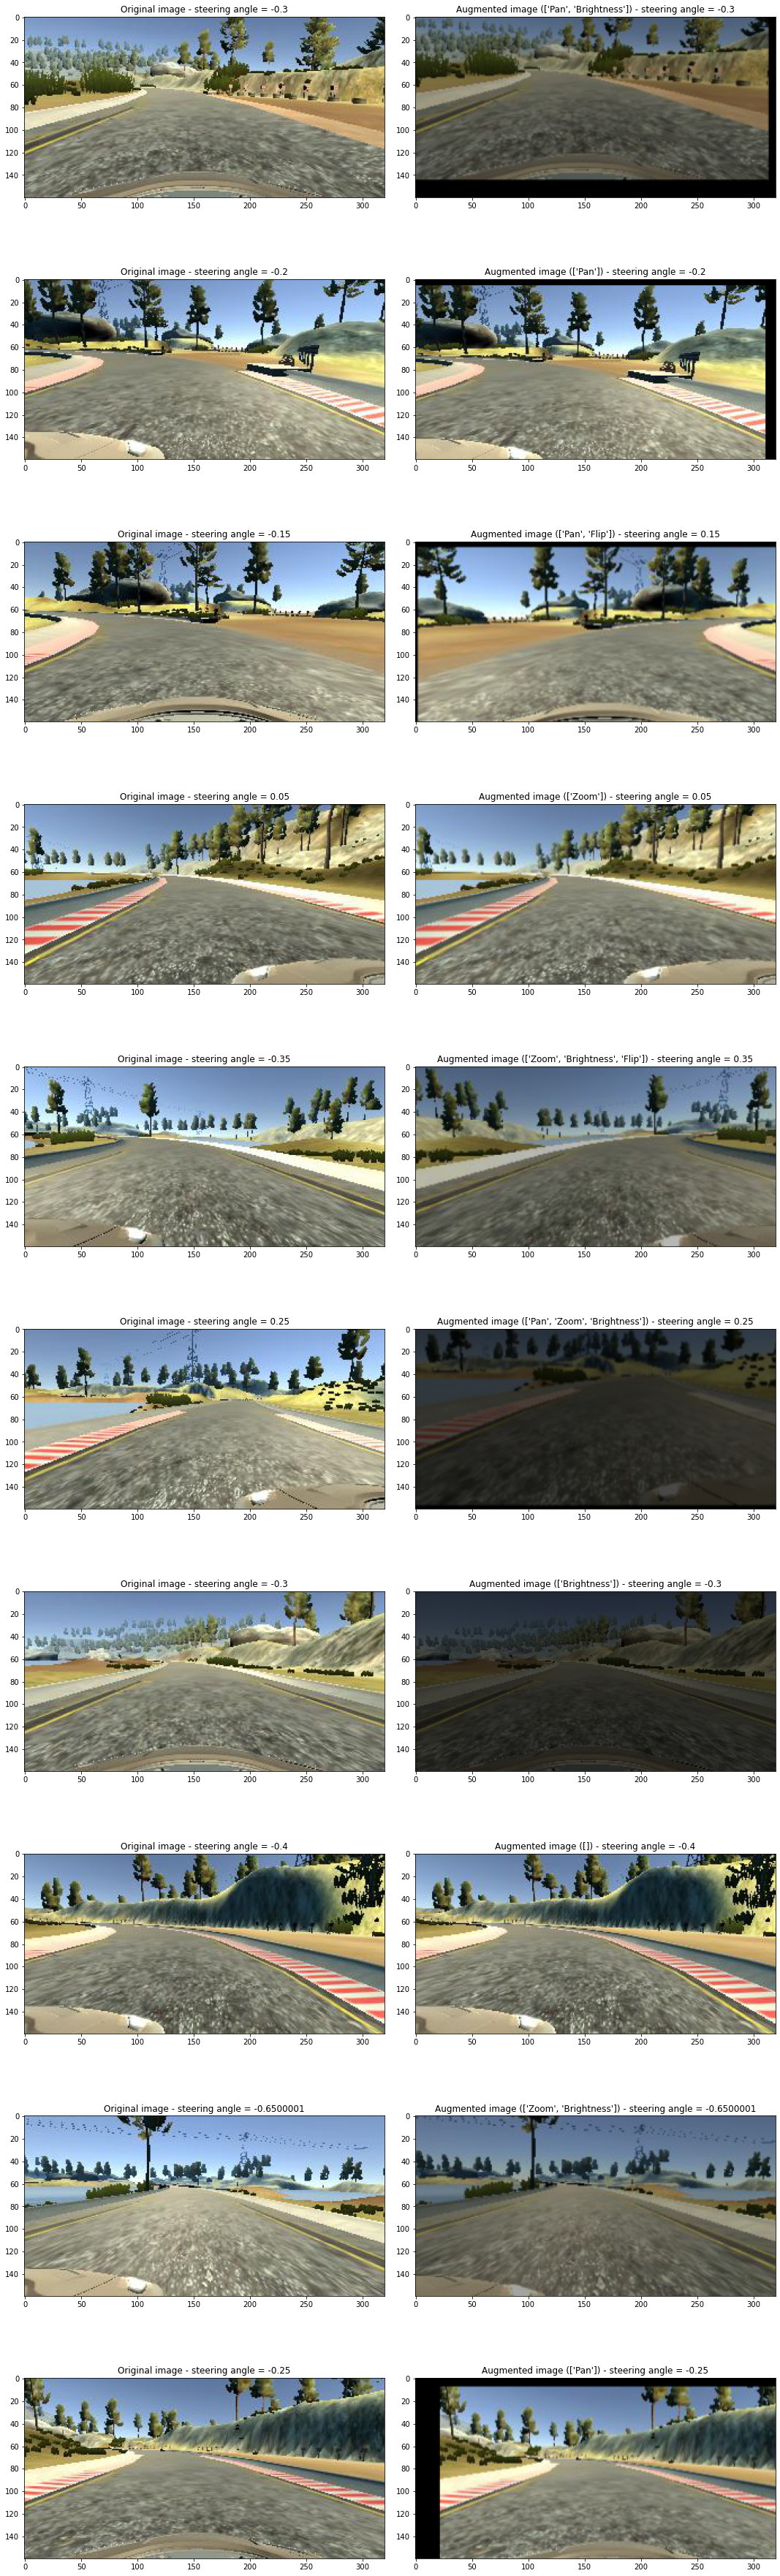

In [69]:
plot_ten_random_augmented_images()

## Preprocessing our data

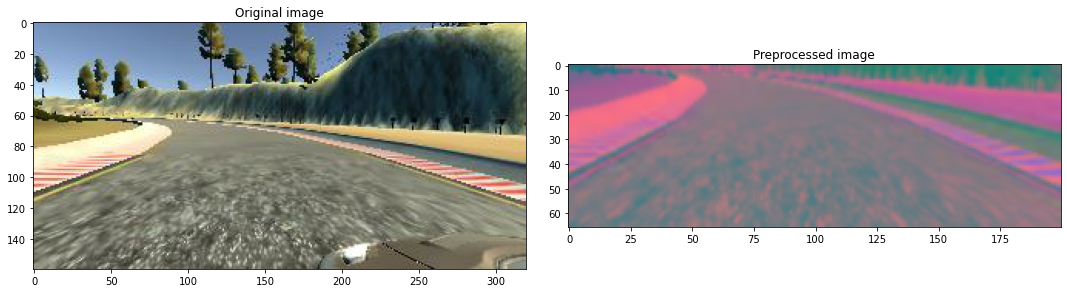

In [57]:
# select a random image to visualize
image = image_paths[100]
original_image = mpimg.imread(image)

preprocessed_image = image_augmentor.image_preprocess(original_image)

plot_two_images(original_image, 
                preprocessed_image, 
                "Original image", 
                "Preprocessed image")

### Batch Image Generator


In [58]:
batch_image_generator = BatchImageGenerator(image_augmentor)

Plot images to verify our generator is working as expected.

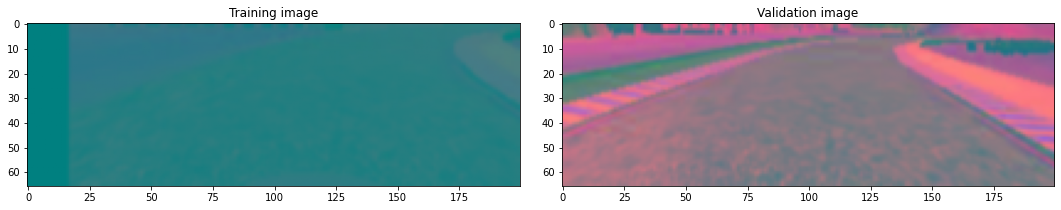

In [59]:
x_train_gen, y_train_gen = next(batch_image_generator.batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_image_generator.batch_generator(X_valid, y_valid, 1, 0))

plot_two_images(x_train_gen[0], 
                x_valid_gen[0], 
                'Training image', 
                'Validation image')

## Defining NVidia Model Architecture for Behavioural Cloning
A popular model used for behavioural cloning is the one proposed by NVidia. It is also implemented in real-life self-driving cars.

We are going to implement this architecture from the paper by [Bojarski, et al. 2016](#References).

![CNN Architecture](./images/CNN_architecture.PNG)


We can see from the diagram that the Nvidia model begins with an Input layer (the Input planes at the bottom of the diagram), and then has a Normalization layer. We are going to skip the Normalization layer in our implementation because we have already normalized the data outside of our model, as part of the image processing. The normalized data is then passed into a convolutional layer.

Note, we can prevent overfitting by using a dropout layer in the model. Note, I experimented with Dropout Layers in different positions in the model at different times, and with varying dropout rates. Eventually, by experimenting with the hyperparameter values during training, I was able to reduce overfitting without the use of dropout layers.
    

In [60]:
model_builder = VehicleControlModelBuilder()
vehicle_control_model = model_builder.nvidia_model()

In [61]:
print(vehicle_control_model.summary())

Model: "Vehicle_Control"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Convolutional_feature_map_24 (None, 31, 98, 24)        1824      
_________________________________________________________________
Convolutional_feature_map_36 (None, 14, 47, 36)        21636     
_________________________________________________________________
Convolutional_feature_map_48 (None, 5, 22, 48)         43248     
_________________________________________________________________
Convolutional_feature_map_64 (None, 3, 20, 64)         27712     
_________________________________________________________________
Convolutional_feature_map_64 (None, 1, 18, 64)         36928     
_________________________________________________________________
Flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
Fully_connected_100 (Dense)  (None, 100)           

## Training the model


In [62]:
model_trainer = ModelTrainer(vehicle_control_model)

In [63]:
epochs, batch_size, steps_per_epoch, validation_steps = model_trainer.hyperparameters()

print("Model hyperparameters:")
print("Epochs = ", epochs)
print("Batch size =", batch_size)
print("Steps per epoch =", steps_per_epoch)
print("Validation Steps =", validation_steps)

Model hyperparameters:
Epochs =  5
Batch size = 150
Steps per epoch = 300
Validation Steps = 200


In [64]:
history = model_trainer.train_model(X_train, y_train, X_valid, y_valid)

Epoch 1/5
300/300 [==============================] - 170s 567ms/step - loss: 0.0991 - accuracy: 0.0895 - mae: 0.2400 - val_loss: 0.0637 - val_accuracy: 0.0859 - val_mae: 0.1962
Epoch 2/5
300/300 [==============================] - 166s 555ms/step - loss: 0.0785 - accuracy: 0.0906 - mae: 0.2136 - val_loss: 0.0596 - val_accuracy: 0.0857 - val_mae: 0.1864
Epoch 3/5
300/300 [==============================] - 165s 552ms/step - loss: 0.0689 - accuracy: 0.0892 - mae: 0.2006 - val_loss: 0.0545 - val_accuracy: 0.0952 - val_mae: 0.1840
Epoch 4/5
300/300 [==============================] - 165s 550ms/step - loss: 0.0621 - accuracy: 0.0904 - mae: 0.1912 - val_loss: 0.0503 - val_accuracy: 0.0917 - val_mae: 0.1765
Epoch 5/5
300/300 [==============================] - 164s 548ms/step - loss: 0.0573 - accuracy: 0.0898 - mae: 0.1842 - val_loss: 0.0525 - val_accuracy: 0.0911 - val_mae: 0.1817


# Visualize the metrics

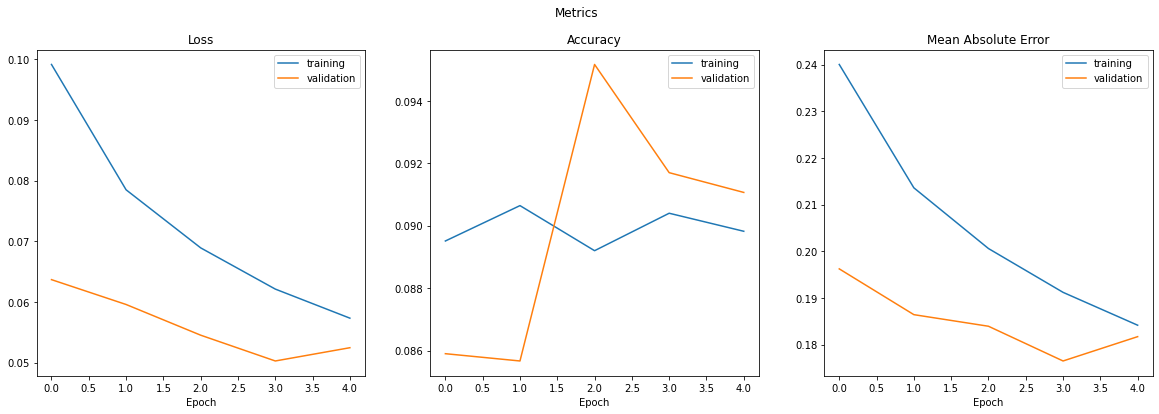

In [65]:
plt.figure(figsize=(20,6))
plt.suptitle("Metrics")


plt.subplot(131)
plt.title('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.xlabel('Epoch')


plt.subplot(132)
plt.title('Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.xlabel('Epoch')


plt.subplot(133)
plt.title('Mean Absolute Error')
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['training', 'validation'])
plt.xlabel('Epoch')

plt.show()

# Save the trained model

At this point, let's save the model, and verify it is saved to the specified location.

In [66]:
models_dir = 'Models'
model_name = 'model.h5'

vehicle_control_model.save(models_dir + '/' + model_name)

In [67]:
!ls $models_dir

model.h5


This is the model I will use in the simulated vehicle. The self-driving car will use this model to control the steering.

# References
* Bojarski, M., Del Testa, D., Dworakowski, D., Firner, B., Flepp, B., Goyal, P., Jackel, L.D., Monfort, M., Muller, U., Zhang, J. and Zhang, X., 2016. [End to end learning for self-driving cars](https://arxiv.org/pdf/1604.07316.pdf). arXiv preprint arXiv:1604.07316.
